In [4]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchsummary import summary

from albumentations import (
    ToFloat, 
    CLAHE, 
    RandomRotate90, 
    Transpose, 
    ShiftScaleRotate, 
    Blur, 
    OpticalDistortion, 
    GridDistortion, 
    HueSaturationValue, 
    IAAAdditiveGaussianNoise, 
    GaussNoise, 
    MotionBlur, 
    MedianBlur, 
    IAAPiecewiseAffine, 
    IAASharpen, 
    IAAEmboss, 
    RandomContrast, 
    RandomBrightness, 
    Flip, 
    OneOf, 
    Compose
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import numbers
from sklearn.model_selection import train_test_split

from PIL import Image
import math
from tqdm import tqdm

In [10]:
model_file_root = '../../models/Kannada-MNIST/'
data_root = '../../data/raw/Kannada-MNIST/'
model_file_ext = '.pt'
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
torch.set_num_threads(4)
np.random.seed(RANDOM_STATE)

rcParams['figure.figsize'] = 16, 16


## 1. transform & dataload

In [11]:
class RandomRotation:

    def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        angle = np.random.uniform(degrees[0], degrees[1])
        return angle

    def __call__(self, img):        
        def rotate(img, angle, resample=False, expand=False, center=None):
            return img.rotate(angle, resample, expand, center)

        angle = self.get_params(self.degrees)
        return rotate(img, angle, self.resample, self.expand, self.center)

In [12]:
class RandomShift(object):
    
    def __init__(self, shift):
        self.shift = shift
        
    @staticmethod
    def get_params(shift):
        hshift, vshift = np.random.uniform(-shift, shift, size=2)
        return hshift, vshift 
    
    def __call__(self, img):
        hshift, vshift = self.get_params(self.shift)
        return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)

In [31]:
class Kannada_MNIST_data(Dataset):
    
    def __init__(self, df, aug=False):
        self.aug = aug
        n_pixels = 28 * 28
        
#         if "id" in df.columns:
#             print("drop")
#             df.drop(["id"], axis=1)
        if "label" not in df.columns:
            # test data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
        
        if self.y is not None and self.aug:
            self.transform = transforms.Compose([
                transforms.ToPILImage(), 
                RandomRotation(degrees=10), 
                RandomShift(3),
                transforms.ToTensor(), 
                transforms.Normalize(mean=(0.5,), std=(0.5,))
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(), 
                transforms.Normalize(mean=(0.5,), std=(0.5,))
            ])
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])


In [32]:
%%time

full_train_df = pd.read_csv(data_root+'train.csv')
test_df = pd.read_csv(data_root+'test.csv')

train_df, valid_df = train_test_split(full_train_df, test_size=0.2, random_state=RANDOM_STATE, shuffle=True)

CPU times: user 3.47 s, sys: 731 ms, total: 4.2 s
Wall time: 4.22 s


In [34]:
batch_size = 64

train_dataset = Kannada_MNIST_data(train_df, aug=True)
valid_dataset = Kannada_MNIST_data(valid_df)
test_dataset = Kannada_MNIST_data(test_df)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [35]:
def show_batch(loader, lb=True):
    batcher = iter(loader)
    if lb:
        images, labels = batcher.next()
    else:
        images = batcher.next()
    grid = torchvision.utils.make_grid(images)

    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    if lb:
        plt.title(labels.numpy());
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


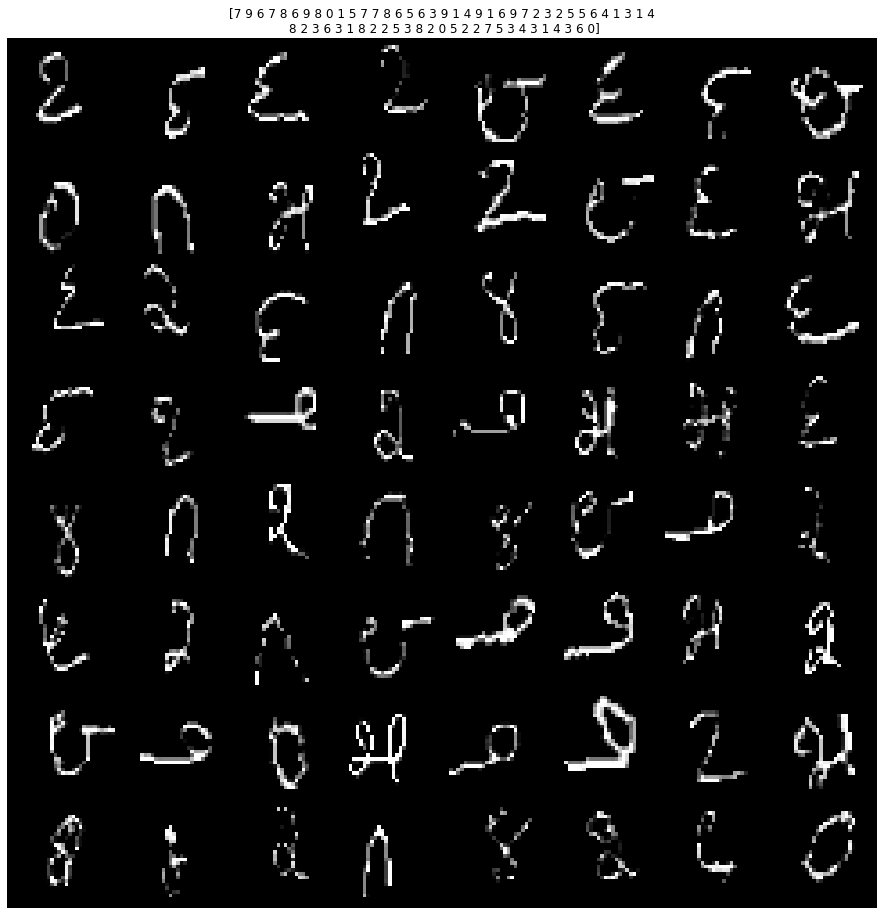

In [36]:
show_batch(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


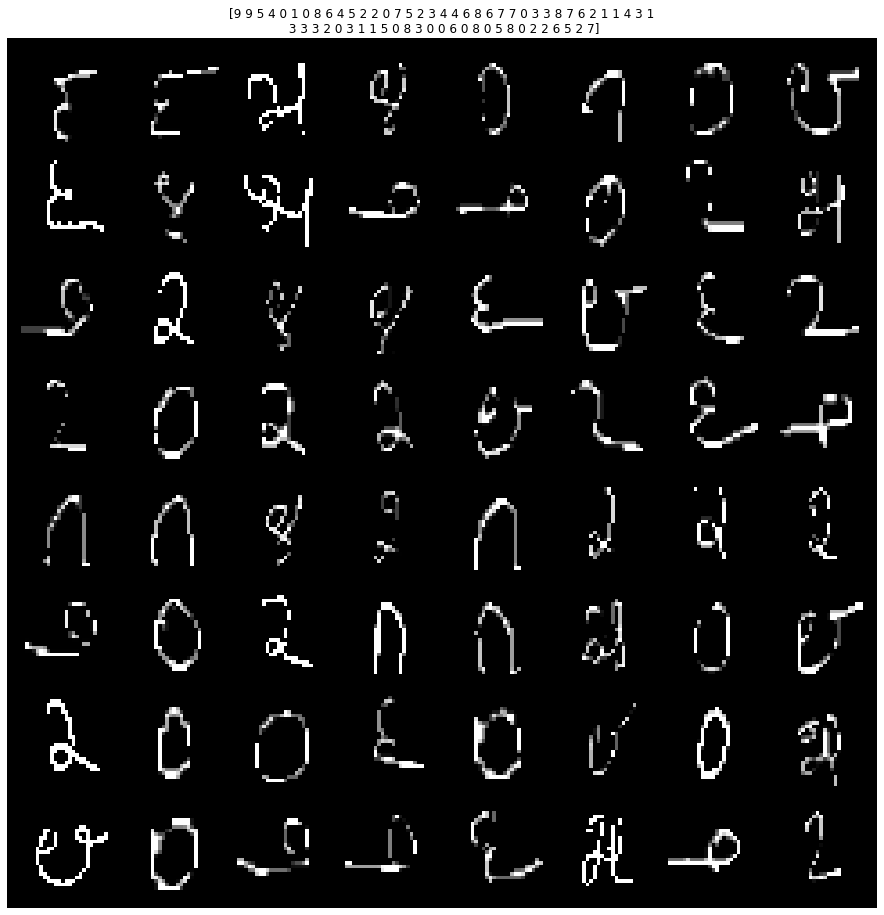

In [37]:
show_batch(valid_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


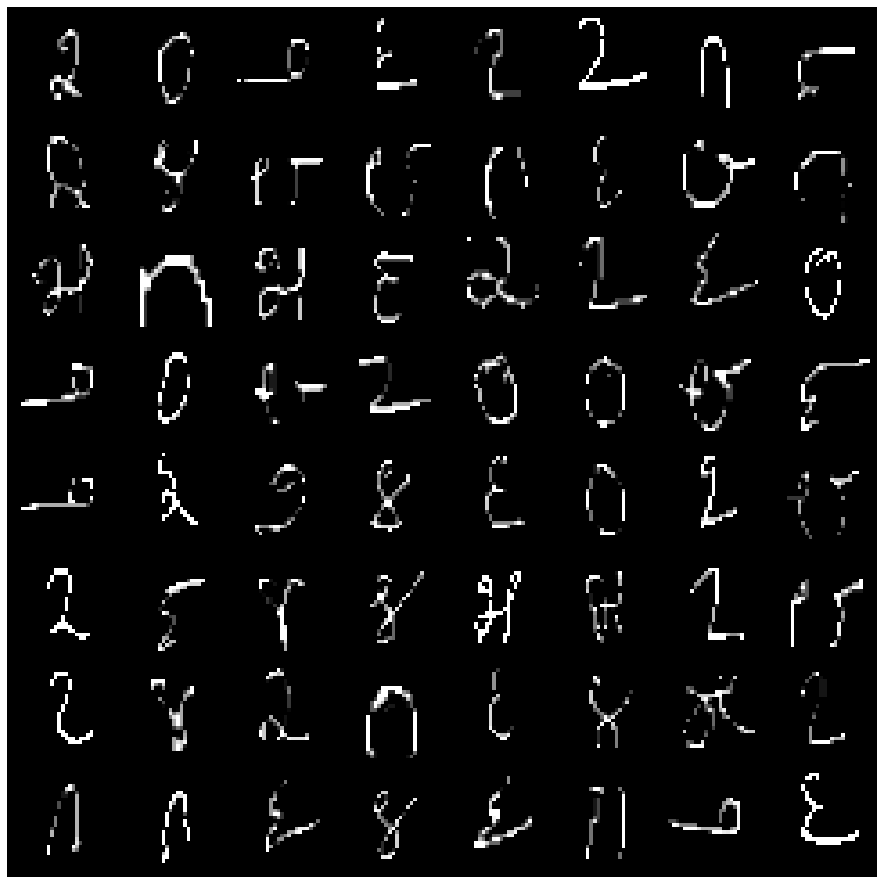

In [38]:
show_batch(test_loader, lb=False)

In [39]:
train_loader, valid_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x143a43cd0>,
 <torch.utils.data.dataloader.DataLoader at 0x143a43610>)

In [40]:
def train(model, train_loader):
    batch_loss = 0.0
    batch_corrects = 0.0
    model.train()
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.max(outputs, 1)[1]
        batch_loss += loss.item()
        batch_corrects += torch.sum(preds == labels.data)
    
    return batch_loss/len(train_loader), batch_corrects.float()/len(train_dataset)

In [41]:
def evaluate(model, valid_loader):
    loss = 0.0
    corrects = 0.0
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = Variable(inputs), Variable(labels)
            outputs = model(inputs)

            loss += F.cross_entropy(outputs, labels, reduction='mean').item()
            pred = outputs.data.max(1, keepdim=True)[1]
            corrects += pred.eq(labels.data.view_as(pred)).cpu().sum()
               
    return loss/len(valid_loader), corrects.float()/len(valid_dataset)

## 1. Test pipeline

In [42]:
class SimpleConvNet(nn.Module):
    
    def __init__(self):
        super(SimpleConvNet, self).__init__()    
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1),        
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),  
            nn.Conv2d(20, 50, 5, 1),
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)  
        )
        self.full_conn_layers = nn.Sequential(
            nn.Linear(4*4*50, 500),        
            nn.ReLU(),
            nn.Linear(500, 10)         
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.full_conn_layers(x)
        return x

In [43]:
model = SimpleConvNet()
epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.3,
    mode="max",
    verbose=True,
    patience=1,
    threshold=1e-3
)

In [44]:
%%time

epoch_loss_history = []
epoch_corrects_history = []
val_loss_history = []
val_corrects_history = []

for epoch in range(epochs):
    epoch_loss, epoch_corrects = train(model, train_loader)
    val_loss, val_corrects = evaluate(model, valid_loader)
    
    epoch_loss_history.append(epoch_loss)
    epoch_corrects_history.append(epoch_corrects)
    val_loss_history.append(val_loss)
    val_corrects_history.append(val_corrects)
    
    print('epoch:', (epoch+1))
    print('training loss: {:.4f}, training acc {:.4f} '.format(epoch_loss, epoch_corrects.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_loss, val_corrects.item()))
    scheduler.step(val_corrects)

epoch: 1
training loss: 0.1963, training acc 0.9414 
validation loss: 0.0517, validation acc 0.9833 
epoch: 2
training loss: 0.0623, training acc 0.9811 
validation loss: 0.0784, validation acc 0.9764 
epoch: 3
training loss: 0.0511, training acc 0.9839 
validation loss: 0.0525, validation acc 0.9845 
epoch: 4
training loss: 0.0456, training acc 0.9862 
validation loss: 0.0212, validation acc 0.9933 
epoch: 5
training loss: 0.0398, training acc 0.9880 
validation loss: 0.0576, validation acc 0.9804 
epoch: 6
training loss: 0.0411, training acc 0.9876 
validation loss: 0.0293, validation acc 0.9932 
Epoch     5: reducing learning rate of group 0 to 3.0000e-03.
epoch: 7
training loss: 0.0226, training acc 0.9928 
validation loss: 0.0148, validation acc 0.9954 
epoch: 8
training loss: 0.0194, training acc 0.9937 
validation loss: 0.0126, validation acc 0.9966 
epoch: 9
training loss: 0.0184, training acc 0.9945 
validation loss: 0.0131, validation acc 0.9956 
epoch: 10
training loss: 0.01

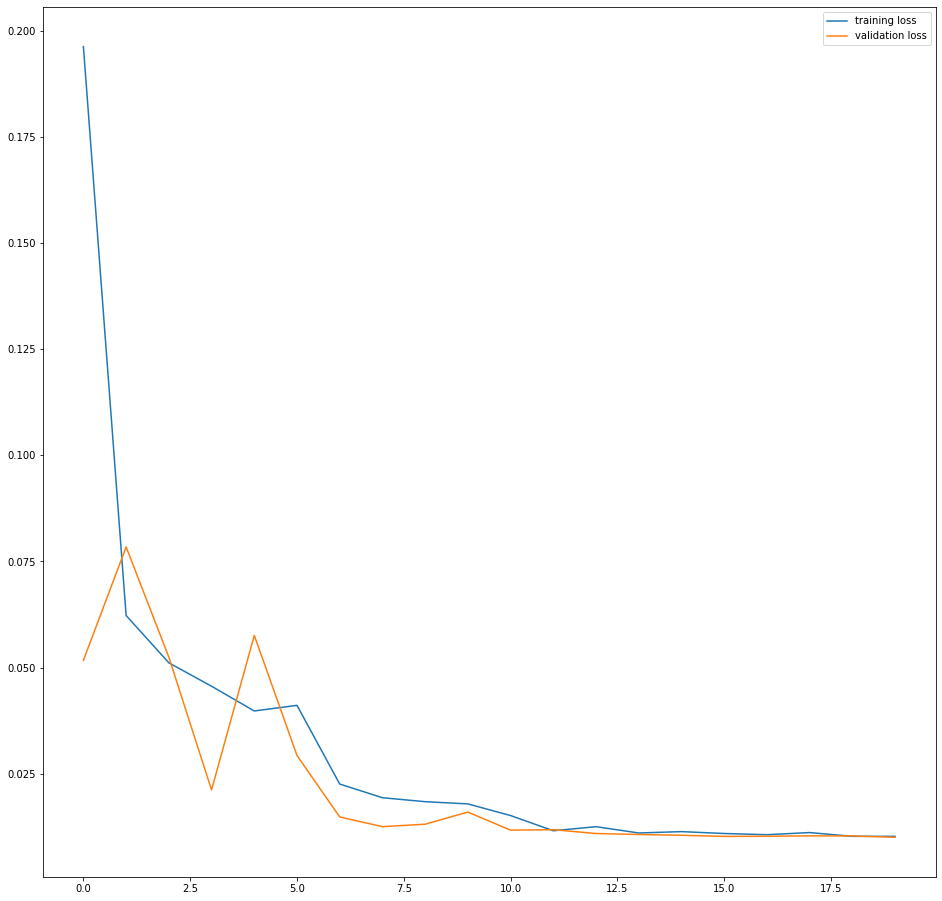

In [47]:
plt.plot(epoch_loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.legend()

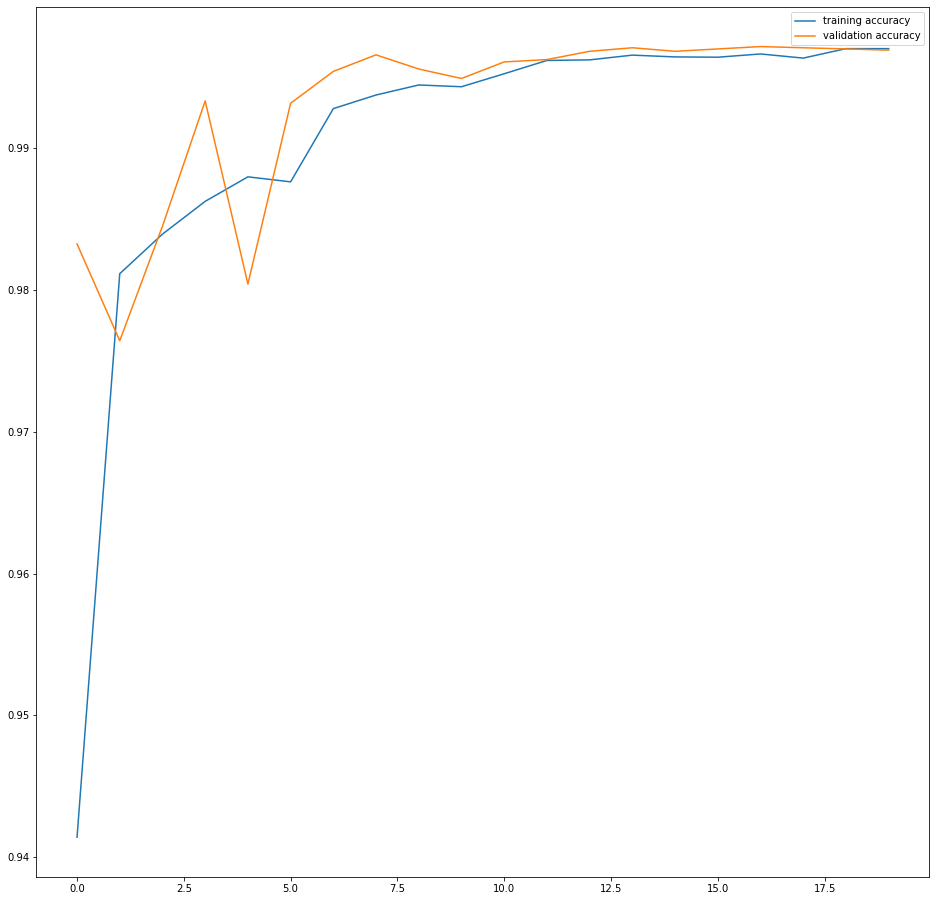

In [48]:
plt.plot(epoch_corrects_history, label='training accuracy')
plt.plot(val_corrects_history, label='validation accuracy')
plt.legend()

In [49]:
path = f"{model_file_root}SimpleNetNet{model_file_ext}"
torch.save(model.state_dict(), path)

## 2. CNN

In [57]:
class Conv2Class2Net(nn.Module):
    def __init__(self):
        super(Conv2Class2Net, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(256, 10)
        )
        
        for m in self.cnn_layers.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.fc_layers.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
    def forward(self, x):
        out = self.cnn_layers(x)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out

In [58]:
model = Conv2Class2Net()
epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.3,
    mode="max",
    verbose=True,
    patience=1,
    threshold=1e-3
)

In [59]:
%%time

epoch_loss_history = []
epoch_corrects_history = []
val_loss_history = []
val_corrects_history = []

for epoch in range(epochs):
    epoch_loss, epoch_corrects = train(model, train_loader)
    val_loss, val_corrects = evaluate(model, valid_loader)
    
    epoch_loss_history.append(epoch_loss)
    epoch_corrects_history.append(epoch_corrects)
    val_loss_history.append(val_loss)
    val_corrects_history.append(val_corrects)
    
    print('epoch:', (epoch+1))
    print('training loss: {:.4f}, training acc {:.4f} '.format(epoch_loss, epoch_corrects.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_loss, val_corrects.item()))
    scheduler.step(val_corrects)
    
    path = f"{model_file_root}Conv2Class2Net_{epoch+1}{model_file_ext}"
    torch.save(model.state_dict(), path)

epoch: 1
training loss: 0.1758, training acc 0.9438 
validation loss: 0.0315, validation acc 0.9908 
epoch: 2
training loss: 0.0802, training acc 0.9768 
validation loss: 0.0424, validation acc 0.9870 
epoch: 3
training loss: 0.0631, training acc 0.9803 
validation loss: 0.0238, validation acc 0.9917 
Epoch     2: reducing learning rate of group 0 to 3.0000e-03.
epoch: 4
training loss: 0.0397, training acc 0.9880 
validation loss: 0.0145, validation acc 0.9962 
epoch: 5
training loss: 0.0325, training acc 0.9899 
validation loss: 0.0134, validation acc 0.9962 
epoch: 6
training loss: 0.0333, training acc 0.9901 
validation loss: 0.0150, validation acc 0.9957 
Epoch     5: reducing learning rate of group 0 to 9.0000e-04.
epoch: 7
training loss: 0.0262, training acc 0.9923 
validation loss: 0.0115, validation acc 0.9969 
epoch: 8
training loss: 0.0219, training acc 0.9933 
validation loss: 0.0116, validation acc 0.9966 
Epoch     7: reducing learning rate of group 0 to 2.7000e-04.
epoch:

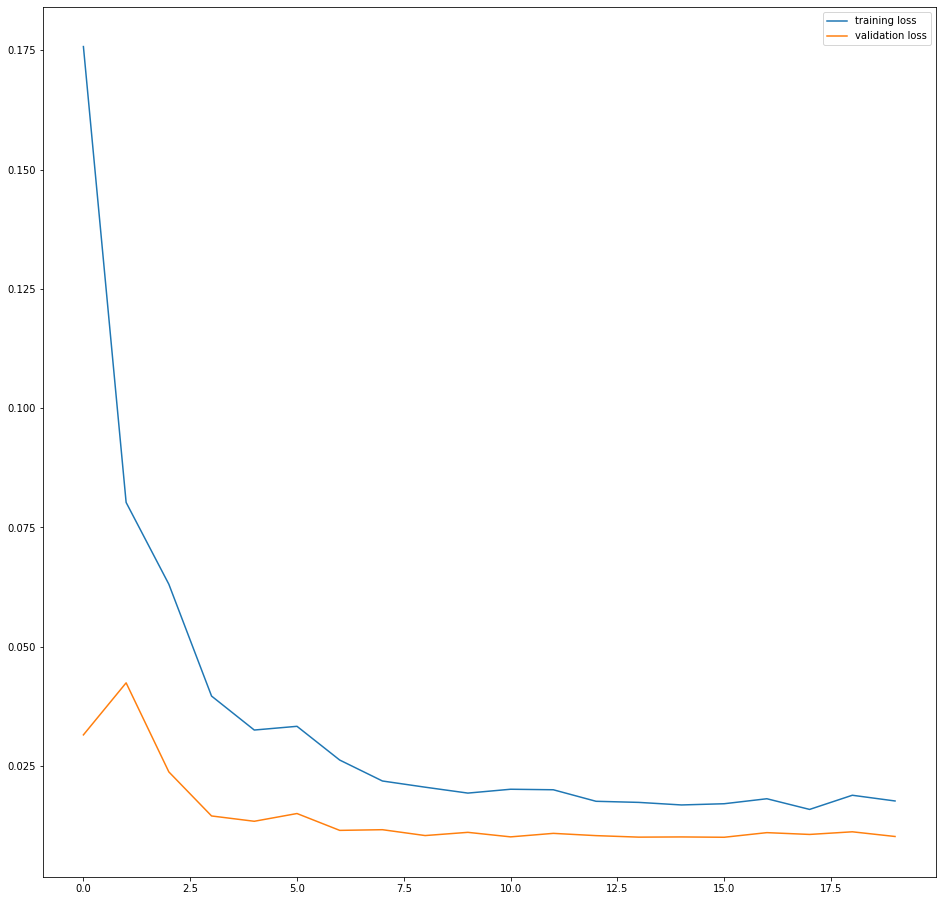

In [60]:
plt.plot(epoch_loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.legend()

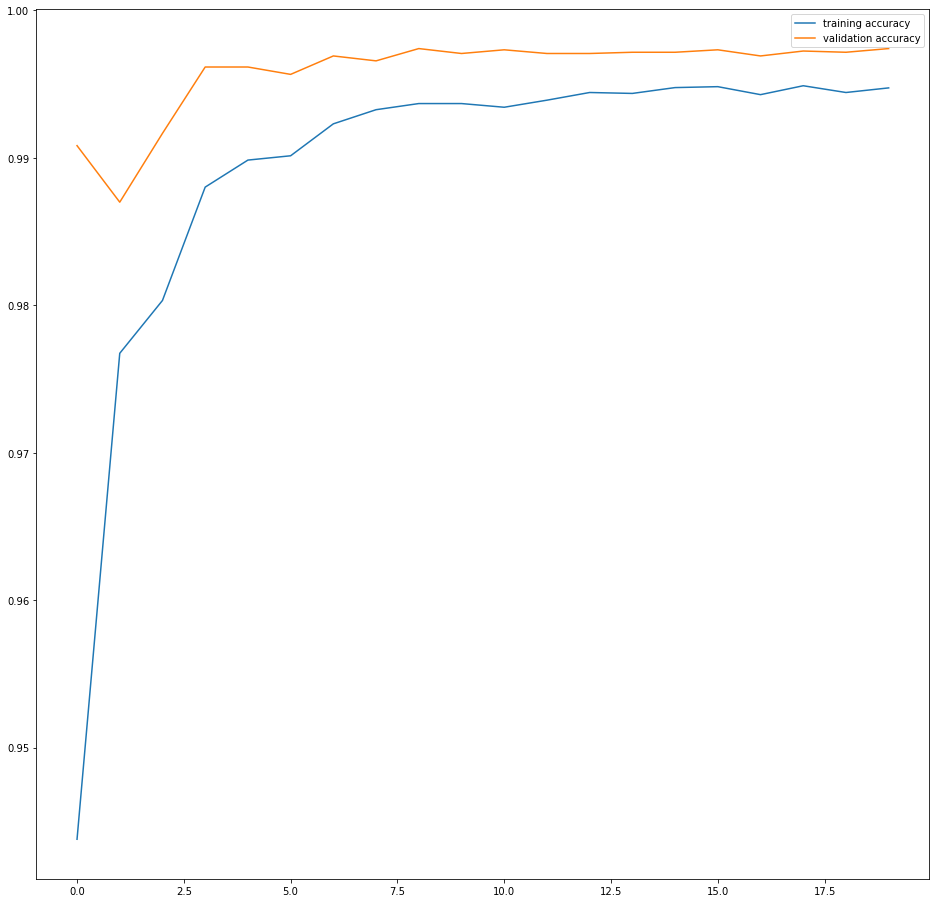

In [61]:
plt.plot(epoch_corrects_history, label='training accuracy')
plt.plot(val_corrects_history, label='validation accuracy')
plt.legend()

## Predict

In [51]:
path = model_file_root+'SimpleNetNet'+model_file_ext
model = SimpleConvNet()
model.load_state_dict(torch.load(path))
model.eval()

SimpleConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (4): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (full_conn_layers): Sequential(
    (0): Linear(in_features=800, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [52]:
def prediciton(model, data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = Variable(data, volatile=True)
            
        output = model(data)
        
        pred = output.data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

In [53]:
%%time
test_pred = prediciton(model, test_loader)

CPU times: user 3.63 s, sys: 90.9 ms, total: 3.72 s
Wall time: 1.01 s


In [54]:
out_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], test_pred.numpy()], columns=['ImageId', 'Label'])

In [55]:
out_df.head()

,ImageId,Label
0,1,3
1,2,0
2,3,2
3,4,6
4,5,7


In [56]:
out_df.to_csv('submission.csv', index=False)